In [53]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from PIL import Image
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Resize
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<h1>Question 1</h1>

In [2]:
df = pd.read_csv("../Assignment3/Grocery_Items_24.csv") 


In [3]:

# referred from https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/

transactions = []
for i in range(len(df)):
    transactions.append([str(item) for item in df.iloc[i, :]])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)


min_support = 0.01  
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

# Generate association rules
min_confidence = 0.1 
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Print the association rules
print("Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']])

Association Rules:
                 antecedents        consequents   support  confidence
0                 (UHT-milk)              (nan)  0.020875    1.000000
1                     (beef)              (nan)  0.034250    1.000000
2                  (berries)              (nan)  0.021250    1.000000
3                (beverages)              (nan)  0.016750    0.992593
4             (bottled beer)              (nan)  0.045250    1.000000
..                       ...                ...       ...         ...
81  (rolls/buns, whole milk)              (nan)  0.013500    1.000000
82              (rolls/buns)  (nan, whole milk)  0.013500    0.120670
83               (nan, soda)       (whole milk)  0.011375    0.121495
84        (soda, whole milk)              (nan)  0.011375    1.000000
85                    (soda)  (nan, whole milk)  0.011375    0.121495

[86 rows x 4 columns]


In [5]:
def count_rules(min_support, min_confidence):
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    return len(rules),rules

# Define the range of min_support values and min_confidence thresholds
min_support_values = [0.001, 0.005, 0.01, 0.05]
min_confidence_thresholds = [0.05, 0.075, 0.1]
assoc_rules = pd.DataFrame(index=min_support_values, columns=min_confidence_thresholds)
results = pd.DataFrame(index=min_support_values, columns=min_confidence_thresholds)

# Iterate over min_support values and min_confidence thresholds to count the number of rules
for min_support in min_support_values:
    for min_confidence in min_confidence_thresholds:
        num_rules,rules = count_rules(min_support, min_confidence)
        results.at[min_support, min_confidence] = num_rules
        assoc_rules.at[min_support, min_confidence] = rules

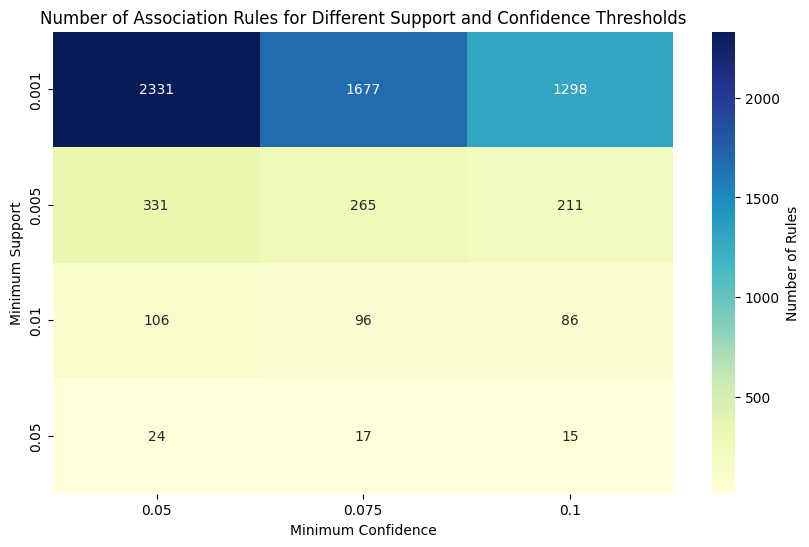

In [6]:
# reffered from https://seaborn.pydata.org/generated/seaborn.heatmap.html
results = results.apply(pd.to_numeric)

plt.figure(figsize=(10, 6))
sns.heatmap(results, annot=True, cmap="YlGnBu", fmt='g', cbar_kws={'label': 'Number of Rules'})
plt.title('Number of Association Rules for Different Support and Confidence Thresholds')
plt.xlabel('Minimum Confidence')
plt.ylabel('Minimum Support')

# Show the plot
plt.show()


In [21]:
min_support = 0.005
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.0)

filtered_rules = rules[rules['support'] >= min_support]

max_confidence_rule = filtered_rules[filtered_rules['confidence'] == filtered_rules['confidence'].max()]

print("Association Rule with the Highest Confidence and Minimum Support 0.005:")
print(max_confidence_rule[['antecedents', 'consequents', 'support', 'confidence']])

Association Rule with the Highest Confidence and Minimum Support 0.005:
                      antecedents consequents   support  confidence
0                      (UHT-milk)       (nan)  0.020875         1.0
3                 (baking powder)       (nan)  0.008500         1.0
5                          (beef)       (nan)  0.034250         1.0
6                       (berries)       (nan)  0.021250         1.0
11                 (bottled beer)       (nan)  0.045250         1.0
..                            ...         ...       ...         ...
468            (soda, whole milk)       (nan)  0.011375         1.0
474                (soda, yogurt)       (nan)  0.006625         1.0
479  (tropical fruit, whole milk)       (nan)  0.008125         1.0
485      (tropical fruit, yogurt)       (nan)  0.006000         1.0
492          (whole milk, yogurt)       (nan)  0.009875         1.0

[113 rows x 4 columns]


The confidence value is 1

<h1>Question 2</h1>


In [56]:
def image_loader(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    img = tf.image.resize(img, [331, 331])
    return img, label

In [74]:
labmap = {0: "n02089078-black-and-tan_coonhound",
          1: "n02091831-Saluki",
          2: "n02092002-Scottish_deerhound",
          3: "n02095314-wire-haired_fox_terrier"}

BATCH_SIZE = 16

# Create TensorFlow dataset
data_set = tf.keras.utils.image_dataset_from_directory(
    "../DataSet/ProcessedDatasets/",
    image_size=(331, 331),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=42
)

# Create DataLoader for validation set
val_data_set = tf.keras.utils.image_dataset_from_directory(
    "../DataSet/ProcessedDatasets/",
    image_size=(331, 331),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 748 files belonging to 4 classes.
Using 599 files for training.
Found 748 files belonging to 4 classes.
Using 149 files for validation.


In [99]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

class MyCNNModel(tf.keras.Model):
    def __init__(self, kernel_size=(3, 3)):
        super(MyCNNModel, self).__init__()
        self.conv1 = layers.Conv2D(8, kernel_size=kernel_size, activation='relu', input_shape=(28, 28, 1))
        self.max_pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = layers.Flatten()
        self.hidden = layers.Dense(16, activation='relu')
        self.fc = layers.Dense(10, activation='softmax')  # Changed to 10 for MNIST

    def call(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.hidden(x)
        x = self.fc(x)
        return x

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = 
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Compile and train the model
model = MyCNNModel()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')


In [100]:

model_kernel_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
